In [273]:
import time
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

    1. Create the dataset (ensure all data is float).
    2. Normalize the features.
    3. Split into training and test sets.
    4. Convert an array of values into a dataset matrix.
    5. Reshape into X=t and Y=t+1.
    6. Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [81]:
dt = pd.read_csv("sales_train_evaluation.csv")
dt.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [82]:
timesteps = 31
startDay = 350 # Eventually minimize this truncation 

In [83]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB
None


In [84]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [85]:
# Reduce memory usage and compare with the previous one to be sure
dt = downcast_dtypes(dt)

In [86]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int16(1941), object(6)
memory usage: 114.3+ MB
None


In [87]:
# Take the transpose so that we have one day for each row, and 30490 items' sales as columns
dt = dt.T  
nbr_time_series = dt.shape[1]
dt.head(10)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,...,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0


In [88]:
#Remove id, item_id, dept_id, cat_id, store_id, state_id columns
dt = dt[6 + startDay:]
dt.head(5)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_351,0,0,0,2,0,0,0,24,3,2,...,0,9,1,0,11,0,0,1,0,0
d_352,0,0,0,0,0,0,0,9,0,2,...,0,5,4,0,8,0,1,2,0,0
d_353,0,0,0,4,2,0,0,2,1,1,...,0,15,2,0,3,0,1,2,0,0
d_354,0,1,0,2,0,0,0,7,1,0,...,0,5,1,0,3,0,0,0,0,0
d_355,0,0,0,1,2,0,0,0,0,0,...,0,7,1,0,1,0,1,1,0,0


In [134]:
calendar = pd.read_csv("calendar.csv")

In [135]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [136]:
# Create dataframe with zeros of 11 features for 1969 days in the calendar
days = pd.DataFrame(np.zeros((1969,11)))

In [137]:
pd.options.mode.chained_assignment = None  # default='warn'
for x, y in calendar.iterrows():
    tag = datetime.datetime.strptime(calendar["date"][x], '%Y-%m-%d')
    days[0][x] = calendar["wday"][x]
    days[1][x] = tag.day
    days[2][x] = tag.isocalendar()[1]
    days[3][x] = calendar["month"][x]
    days[4][x] = calendar["year"][x]
    days[5][x] = calendar["snap_CA"][x]
    days[6][x] = calendar["snap_TX"][x]
    days[7][x] = calendar["snap_WI"][x]
    if not pd.isnull(calendar["event_name_1"][x]):
        days[8][x] = calendar["event_name_1"][x]
        days[9][x-1] = 1
        days[10][x+1] = 1

events_encoded = pd.get_dummies(days[[8]], prefix = 'event', drop_first = True)
days = pd.concat([days, events_encoded], axis=1)
days = days.drop([8], axis=1)
del calendar

In [138]:
# "days_test" will be used as input for predicting (We will forecast the days 1941-1969)
daysTest = days[1941:1969]

# "days" will be used for training as a feature.
days = days[startDay:1941]

In [95]:
# Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
days = days.rename(columns={0: "wday", 1: "mday", 2: "week", 3: "month", 4: "year", 5: "week", 6: "snap_CA", 
                          7: "snap_TX", 8: "snap_WI", 9: "before_event", 10: "after_event"})
days.index = dt.index
dt = pd.concat([dt, days], axis=1)

In [96]:
#Feature Scaling
scaler = MinMaxScaler(feature_range = (0,1))
dt_scaled = scaler.fit_transform(dt)

In [97]:
# timesteps = 31
# startDay = 350

# train: [350:1941]
# test: [1941:1969]

X_train = []
y_train = []

nbr_time_series = 30490

# Take a subset of data of timesteps prior days and predict the (timesteps+1)th day
for i in range(timesteps, 1941 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:nbr_time_series])

# when timestep = 14

# when i=14 
# X_train.append(dt_scaled[0:14])
# y_train.append(dt_scaled[14][0:30490])

# when i=15
# X_train.append(dt_scaled[1:15])
# y_train.append(dt_scaled[15][0:30490])

# ...

# when i=1590
# X_train.append(dt_scaled[1576:1590])
# y_train.append(dt_scaled[1590][0:30490])

# X_train is a list of 1576 dataframes of shape(14,30490)
# y_train is a list of 1576 series of shape(1,30490)

In [98]:
del dt_scaled

This transformation to numpy array object will creat **1577** observations with **14** times **30490** features, which are the sales of the prior **14** days, and **14** times 1 features, which are the event information of each **14** days for each observations.

In [99]:
# Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1560, 31, 30530)
(1560, 30490)


An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence. We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [100]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=400
regressor.add(LSTM(units = layer_2_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 30490))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN)

Train on 1560 samples
Epoch 1/32
1560/1560 [==============================] - 175s 112ms/sample - loss: 0.0179
Epoch 2/32
1560/1560 [==============================] - 234s 150ms/sample - loss: 0.0156
Epoch 3/32
1560/1560 [==============================] - 213s 137ms/sample - loss: 0.0152
Epoch 4/32
1560/1560 [==============================] - 257s 165ms/sample - loss: 0.0149
Epoch 5/32
1560/1560 [==============================] - 236s 151ms/sample - loss: 0.0147
Epoch 6/32
1560/1560 [==============================] - 256s 164ms/sample - loss: 0.0145
Epoch 7/32
1560/1560 [==============================] - 223s 143ms/sample - loss: 0.0143
Epoch 8/32
1560/1560 [==============================] - 221s 142ms/sample - loss: 0.0142
Epoch 9/32
1560/1560 [==============================] - 173s 111ms/sample - loss: 0.0141
Epoch 10/32
1560/1560 [==============================] - 188s 121ms/sample - loss: 0.0140
Epoch 11/32
1560/1560 [==============================] - 180s 115ms/sample - loss: 0.01

In [409]:
# We need the last timesteps days of the training set
inputs= dt[-timesteps:]
inputs = scaler.transform(inputs)

In [410]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

In [411]:
X_test.shape

(1, 31, 30530)

In [412]:
num_features = 30530
forecast_horizon = 28
for j in range(timesteps, timesteps + forecast_horizon):
    predicted_sales = regressor.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, num_features))
    testInput = np.append(predicted_sales, daysTest.iloc[0].to_numpy().reshape(1,40)).reshape(1,num_features)    
    X_test = np.append(X_test, testInput).reshape(1,j + 1, num_features)
    predicted_sales = scaler.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_sales)

In [413]:
preiction_total = []

for i in range(len(predictions)):
    preiction_total.append(sum(predictions[i].tolist()[0]))
    
index_sales_total = pd.Index([i for i in range(351,1942)])
index_prediction_total = pd.Index([i for i in range(1942, 1942+forecast_horizon)])

sales_total = pd.DataFrame(dt.iloc[:,0:30490].sum(axis=1))
sales_total['index'] = pd.Series([i for i in range(351,1942)], index=sales_total.index)
sales_total = sales_total.set_index('index')[0]
preiction_total = pd.Series(preiction_total, index=index_prediction_total)

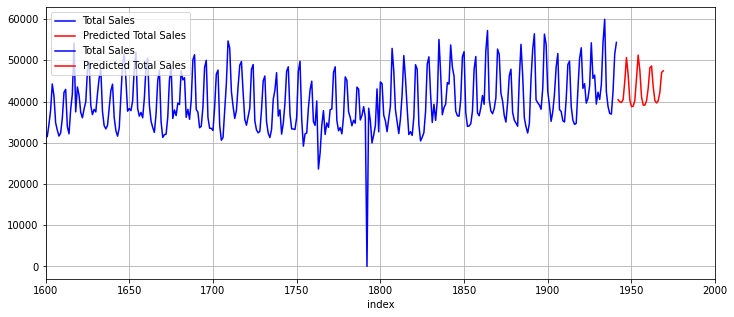

In [415]:
plt.figure(figsize=(12,5))
plt.xlabel('Total sales')
ax1 = sales_total.plot(color='blue', grid=True, label='Total Sales')
ax2 = preiction_total.plot(color='red', grid=True, secondary_y=False, label='Predicted Total Sales')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)
plt.xlim((1600, 2000))
plt.show()
#del preiction_total, sales_total, index_sales_total, index_preiction_total

In [401]:
submission = pd.DataFrame(data=np.array(predictions[0:28]).reshape(28,30490))
submission = submission.T
submission = pd.concat((submission, submission), ignore_index=True)
sample_submission = pd.read_csv("sample_submission.csv")
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("submission_lstm.csv", index=False)
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.954295,0.999673,1.030261,1.116164,1.429382,1.576198,1.081969,0.928553,0.946901,...,1.257938,1.447293,1.230993,0.998683,0.981015,0.998738,1.032606,1.134495,1.300291,1.099302
1,HOBBIES_1_002_CA_1_validation,0.260834,0.265465,0.259339,0.251660,0.294776,0.335779,0.255879,0.210881,0.232598,...,0.465509,0.501183,0.416837,0.313240,0.298620,0.324178,0.324189,0.341728,0.357820,0.283341
2,HOBBIES_1_003_CA_1_validation,0.469276,0.547209,0.641868,0.803215,1.126380,1.179933,0.766785,0.574999,0.578121,...,0.770251,0.955388,0.762897,0.447538,0.367597,0.398039,0.445677,0.585226,0.814725,0.642333
3,HOBBIES_1_004_CA_1_validation,1.228680,1.112422,1.187118,1.360900,1.710836,2.432009,1.897314,1.142514,1.015079,...,1.940979,3.054017,3.690696,2.690598,1.856830,1.606690,1.597302,1.828185,2.610259,3.109136
4,HOBBIES_1_005_CA_1_validation,1.218507,1.296368,1.323614,1.273621,1.229845,1.508385,1.347696,1.215382,1.269277,...,1.431188,1.477122,1.559979,1.426397,1.410563,1.407119,1.352761,1.253123,1.149179,1.193733


To do:
1. Implement Multi-Step models (vector output or encoder-decoder)
2. Implement LSTM-MSNet